# Lesson 7 — Transformers, Attention & Pre-trained Models

This notebook explores the attention mechanism and how modern NLP models (BERT, GPT) leverage it.

**Topics covered:**
1. **Self-Attention from Scratch**: Implementing scaled dot-product attention in PyTorch.
2. **Positional Encoding**: Adding position information to embeddings.
3. **Using Pre-trained Models**: Hugging Face Transformers for sentiment analysis and text generation.
4. **Visualizing Attention**: Inspecting what the model "looks at".

In [1]:
# Install required packages (uncomment if needed)
# !pip install torch transformers matplotlib numpy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.6.0


## 1. Scaled Dot-Product Attention from Scratch

The core attention formula:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) V$$

Where:
- **Q** (Query): What we're looking for
- **K** (Key): What each position offers
- **V** (Value): The actual content to retrieve

In [3]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        query: (batch, seq_len, d_k)
        key:   (batch, seq_len, d_k)
        value: (batch, seq_len, d_v)
        mask:  Optional mask (batch, seq_len, seq_len)
    
    Returns:
        output: (batch, seq_len, d_v)
        attention_weights: (batch, seq_len, seq_len)
    """
    d_k = query.size(-1)
    
    # Compute attention scores: Q @ K^T / sqrt(d_k)
    scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
    
    # Apply mask if provided (e.g., for causal attention in GPT)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Weighted sum of values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

In [4]:
# Example: Self-attention on a small sequence
batch_size = 1
seq_len = 4
d_model = 8

# Simulate input embeddings (e.g., for "The cat sat mat")
x = torch.randn(batch_size, seq_len, d_model)
print(f"Input shape: {x.shape}")

# In self-attention, Q, K, V all come from the same input
# In practice, we'd project through learned weight matrices
Q = x
K = x
V = x

output, attn_weights = scaled_dot_product_attention(Q, K, V)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

Input shape: torch.Size([1, 4, 8])
Output shape: torch.Size([1, 4, 8])
Attention weights shape: torch.Size([1, 4, 4])


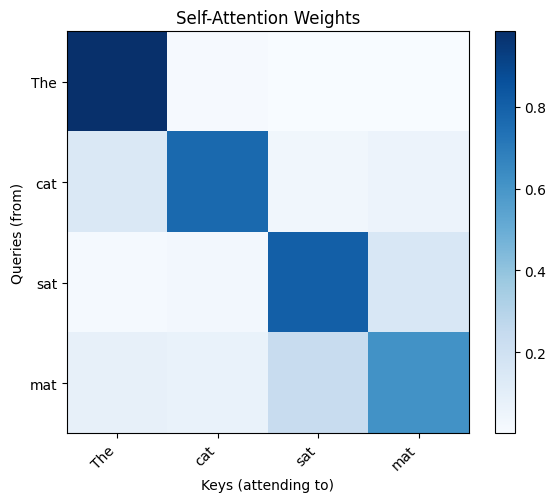

In [5]:
# Visualize attention weights
def plot_attention(attn_weights, tokens=None):
    """Plot attention weights as a heatmap."""
    weights = attn_weights.squeeze(0).detach().numpy()
    
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(weights, cmap='Blues')
    
    if tokens:
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens)
        ax.set_yticklabels(tokens)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    ax.set_xlabel("Keys (attending to)")
    ax.set_ylabel("Queries (from)")
    ax.set_title("Self-Attention Weights")
    
    # Add colorbar
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

tokens = ["The", "cat", "sat", "mat"]
plot_attention(attn_weights, tokens)

## 2. Causal (Masked) Attention for GPT-style Models

In autoregressive models like GPT, each position can only attend to previous positions. We achieve this with a causal mask.

In [6]:
def create_causal_mask(seq_len):
    """Create a lower-triangular mask for causal attention."""
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

# Visualize the causal mask
causal_mask = create_causal_mask(seq_len)
print("Causal mask (1 = can attend, 0 = cannot attend):")
print(causal_mask)

Causal mask (1 = can attend, 0 = cannot attend):
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])



Causal attention weights:


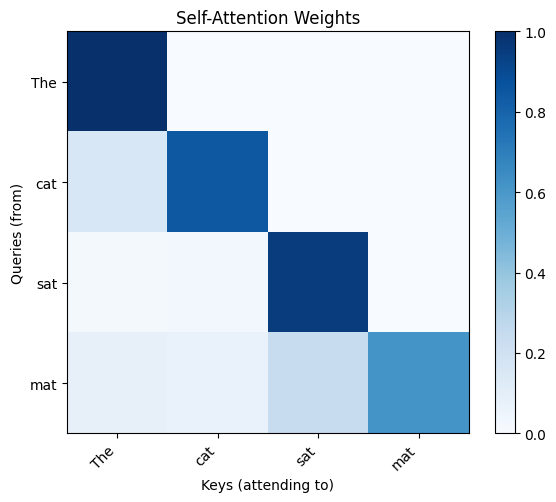

In [7]:
# Apply causal attention
output_causal, attn_weights_causal = scaled_dot_product_attention(Q, K, V, mask=causal_mask)

print("\nCausal attention weights:")
plot_attention(attn_weights_causal, tokens)

Notice how each position can only "see" itself and previous positions — this is how GPT generates text left-to-right.

## 3. Positional Encoding

Self-attention is permutation invariant — it doesn't know word order! We add positional encodings to inject position information.

In [8]:
class SinusoidalPositionalEncoding(nn.Module):
    """Sinusoidal positional encoding from 'Attention Is All You Need'."""
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Compute the div_term for sin/cos frequencies
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a parameter)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

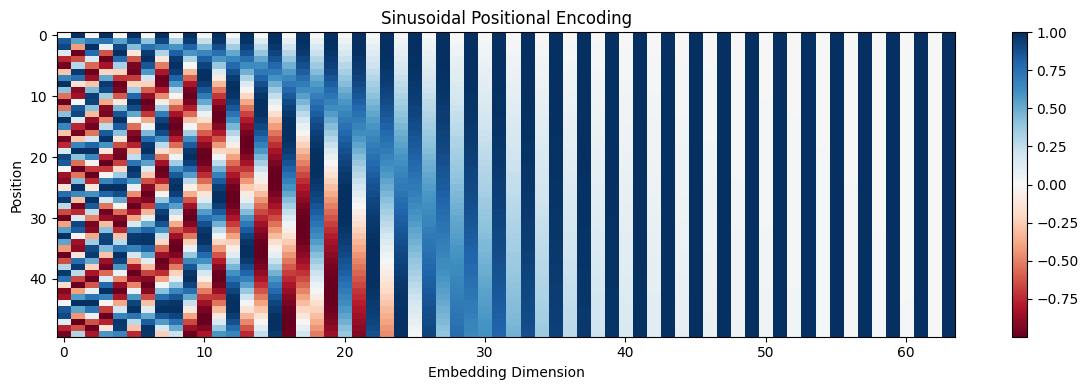

In [9]:
# Visualize positional encodings
d_model = 64
max_len = 100

pos_encoder = SinusoidalPositionalEncoding(d_model, max_len)
pe = pos_encoder.pe.squeeze(0).numpy()

plt.figure(figsize=(12, 4))
plt.imshow(pe[:50, :], aspect='auto', cmap='RdBu')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Sinusoidal Positional Encoding')
plt.colorbar()
plt.tight_layout()
plt.show()

Each position has a unique pattern. The sinusoidal design allows the model to extrapolate to longer sequences than seen during training.

## 4. Multi-Head Attention

Instead of one attention operation, we use multiple "heads" that can focus on different aspects (syntax, semantics, etc.).

In [10]:
class MultiHeadAttention(nn.Module):
    """Multi-head self-attention module."""
    
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project to Q, K, V
        Q = self.W_q(x)  # (batch, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Reshape to (batch, n_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention for each head
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)  # (batch, n_heads, seq_len, d_k)
        
        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(attn_output)
        
        return output, attn_weights

In [11]:
# Test multi-head attention
d_model = 64
n_heads = 4
seq_len = 6
batch_size = 1

mha = MultiHeadAttention(d_model, n_heads)
x = torch.randn(batch_size, seq_len, d_model)

output, attn_weights = mha(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}  # (batch, n_heads, seq_len, seq_len)")

Input shape: torch.Size([1, 6, 64])
Output shape: torch.Size([1, 6, 64])
Attention weights shape: torch.Size([1, 4, 6, 6])  # (batch, n_heads, seq_len, seq_len)


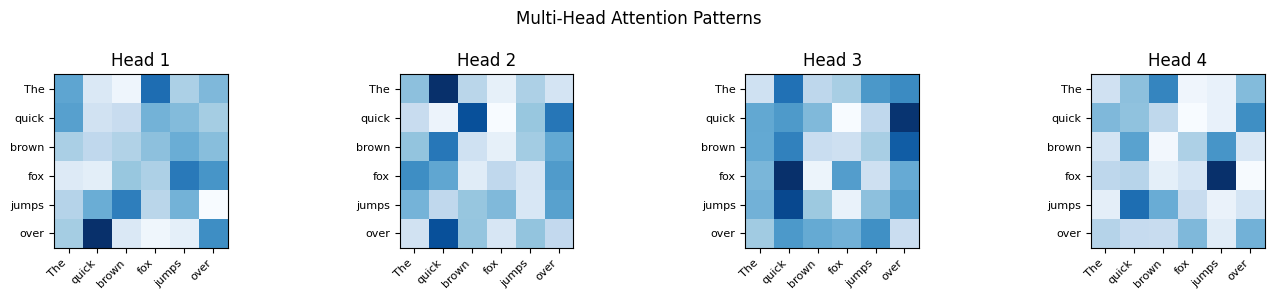

In [12]:
# Visualize attention from each head
tokens = ["The", "quick", "brown", "fox", "jumps", "over"]

fig, axes = plt.subplots(1, n_heads, figsize=(14, 3))
for head_idx in range(n_heads):
    weights = attn_weights[0, head_idx].detach().numpy()
    ax = axes[head_idx]
    im = ax.imshow(weights, cmap='Blues')
    ax.set_title(f"Head {head_idx + 1}")
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)

plt.suptitle("Multi-Head Attention Patterns")
plt.tight_layout()
plt.show()

Different heads learn to focus on different relationships!

## 5. Using Pre-trained Models with Hugging Face 🤗

In practice, we rarely train Transformers from scratch. Let's use pre-trained BERT and GPT models.

In [14]:
# Install transformers if not already installed
# !pip install transformers

from transformers import pipeline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 20.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.1.7
    Uninstalling huggingface_hub-1.1.7:
      Successfully uninstalled huggingface_hub-1.1.7

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


/Users/aghasi/repos/pa-academy-ai-2025/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 5.1 Sentiment Analysis with BERT

In [15]:
# Load a pre-trained sentiment analysis pipeline (BERT-based)
sentiment_analyzer = pipeline("sentiment-analysis")

# Test on some examples
texts = [
    "I absolutely loved this movie! The acting was incredible.",
    "What a waste of time. Terrible plot and boring characters.",
    "It was okay, not great but not bad either.",
    "The special effects were amazing but the story was weak."
]

print("Sentiment Analysis Results:")
print("-" * 60)
for text in texts:
    result = sentiment_analyzer(text)[0]
    print(f"Text: {text[:50]}...")
    print(f"  → {result['label']} (confidence: {result['score']:.3f})")
    print()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


Sentiment Analysis Results:
------------------------------------------------------------
Text: I absolutely loved this movie! The acting was incr...
  → POSITIVE (confidence: 1.000)

Text: What a waste of time. Terrible plot and boring cha...
  → NEGATIVE (confidence: 1.000)

Text: It was okay, not great but not bad either....
  → POSITIVE (confidence: 0.998)

Text: The special effects were amazing but the story was...
  → NEGATIVE (confidence: 0.999)



### 5.2 Fill-Mask with BERT (Masked Language Modeling)

In [16]:
# Load fill-mask pipeline
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

# Test BERT's ability to predict masked words
masked_sentences = [
    "The cat [MASK] on the mat.",
    "Paris is the capital of [MASK].",
    "I love eating [MASK] for breakfast."
]

print("Fill-Mask Predictions:")
print("-" * 60)
for sentence in masked_sentences:
    predictions = fill_mask(sentence)
    print(f"Input: {sentence}")
    print("Top predictions:")
    for pred in predictions[:3]:
        print(f"  - '{pred['token_str']}' (score: {pred['score']:.3f})")
    print()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


Fill-Mask Predictions:
------------------------------------------------------------
Input: The cat [MASK] on the mat.
Top predictions:
  - 'sat' (score: 0.168)
  - 'lay' (score: 0.083)
  - 'was' (score: 0.062)

Input: Paris is the capital of [MASK].
Top predictions:
  - 'france' (score: 0.951)
  - 'algeria' (score: 0.012)
  - 'morocco' (score: 0.003)

Input: I love eating [MASK] for breakfast.
Top predictions:
  - 'it' (score: 0.061)
  - 'something' (score: 0.058)
  - 'pancakes' (score: 0.051)



### 5.3 Text Generation with GPT-2

In [17]:
# Load text generation pipeline with GPT-2
text_generator = pipeline("text-generation", model="gpt2")

# Generate text continuations
prompts = [
    "Once upon a time in a land far away,",
    "The future of artificial intelligence is",
    "In the year 2050, humans discovered that"
]

print("GPT-2 Text Generation:")
print("-" * 60)
for prompt in prompts:
    result = text_generator(
        prompt, 
        max_length=50, 
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7
    )[0]
    print(f"Prompt: {prompt}")
    print(f"Generated: {result['generated_text']}")
    print()

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


GPT-2 Text Generation:
------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Once upon a time in a land far away,
Generated: Once upon a time in a land far away, the universe has been formed. There are many different realms of existence in the universe, but there are also many different realms of reality. The universe is created by the forces of nature. In the universe, there are many different realms of existence, but there are also many different realms of reality. The universe is created with the energy of the sun. In the universe, there are many different realms of existence, but there are also many different realms of reality. The universe is created with electricity. In the universe, there are many different realms of existence, but there are also many different realms of reality. The universe is created with the power of the spirit. In the universe, there are many different realms of existence, but there are also many different realms of reality. The universe is created with the power of the wind. In the universe, there are many different realms 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: The future of artificial intelligence is
Generated: The future of artificial intelligence is looking bright.

More than 100 companies are experimenting with AI in the coming years that could make it possible to run artificial intelligence and automate their jobs with no human input. IBM, Google, Intel, and a number of others have already created artificial intelligence, with the goal of making it easy to run things like predictive algorithms on robots. IBM estimates that by 2021, there could be about 1 billion AI jobs out of the work force.

"There is a lot of work being done in AI," says Chris Hirsch, director of the Carnegie Center for AI and Machine Learning at the University of Michigan's Watson Institute. "It's still early days, but the challenge is to create a human-like AI program that can execute tasks."

And with a lot of work being done, one of the biggest challenges comes in areas like human-like interaction. Many humans are working with machines, and the number of h

## 6. Visualizing BERT Attention Weights

Let's look inside BERT to see what it attends to.

In [ ]:
from transformers import BertTokenizer, BertModel

# Load BERT model with attention output
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# Prepare input
text = "The cat sat on the mat."
inputs = tokenizer(text, return_tensors="pt")

# Get outputs with attention weights
with torch.no_grad():
    outputs = model(**inputs)

# Extract attention weights
attentions = outputs.attentions  # tuple of (batch, n_heads, seq_len, seq_len) for each layer
print(f"Number of layers: {len(attentions)}")
print(f"Shape per layer: {attentions[0].shape}")

In [ ]:
# Get tokens for labeling
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(f"Tokens: {tokens}")

# Visualize attention from the last layer, first few heads
layer_idx = -1  # Last layer
attn = attentions[layer_idx][0]  # (n_heads, seq_len, seq_len)

n_heads_to_show = 4
fig, axes = plt.subplots(1, n_heads_to_show, figsize=(16, 4))

for head_idx in range(n_heads_to_show):
    weights = attn[head_idx].numpy()
    ax = axes[head_idx]
    im = ax.imshow(weights, cmap='Blues')
    ax.set_title(f"Head {head_idx + 1}")
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)

plt.suptitle(f"BERT Attention Patterns (Layer {len(attentions)})")
plt.tight_layout()
plt.show()

## 7. Comparing BERT vs GPT on the Same Input

BERT uses bidirectional context; GPT uses left-to-right (causal) context.

In [ ]:
# BERT: Bidirectional - can see all context
bert_input = "The [MASK] barked loudly at the cat."
bert_predictions = fill_mask(bert_input)

print("BERT (bidirectional):")
print(f"Input: {bert_input}")
print("Top predictions:")
for pred in bert_predictions[:3]:
    print(f"  - '{pred['token_str']}' (score: {pred['score']:.3f})")

In [ ]:
# GPT: Left-to-right - completes the sentence
gpt_input = "The dog barked loudly at the"
gpt_completion = text_generator(
    gpt_input, 
    max_length=15, 
    num_return_sequences=3,
    do_sample=True,
    temperature=0.8
)

print("\nGPT-2 (autoregressive):")
print(f"Input: {gpt_input}")
print("Completions:")
for i, result in enumerate(gpt_completion):
    print(f"  {i+1}. {result['generated_text']}")

**Key Insight:**
- BERT "understands" by looking at surrounding context → good for classification, QA, NER
- GPT "generates" by predicting what comes next → good for text generation, chatbots

## 8. Exercise Ideas

Try these to deepen your understanding:

1. **Experiment with attention:** Modify the scaled dot-product attention to use different scaling factors. What happens?

2. **Compare models:** Try different pre-trained models (e.g., `distilbert-base-uncased`, `roberta-base`) for sentiment analysis. Which works best?

3. **Prompt engineering:** Experiment with different prompts for GPT-2 text generation. How does the prompt affect the output?

4. **Attention visualization:** Choose a longer sentence and visualize attention across different layers. Do earlier and later layers focus on different things?

5. **Fine-tuning:** Use the Hugging Face Trainer to fine-tune a BERT model on a small classification dataset (e.g., IMDB reviews).

## Summary

In this notebook, we covered:

- **Scaled dot-product attention**: The core operation that allows models to focus on relevant parts of the input.
- **Causal masking**: How GPT-style models ensure left-to-right generation.
- **Positional encoding**: Adding position information to permutation-invariant attention.
- **Multi-head attention**: Using multiple attention heads to capture different relationships.
- **Pre-trained models**: Leveraging BERT for understanding and GPT for generation.

These concepts are the foundation of modern NLP — from ChatGPT to search engines to translation systems.